In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
from os.path import abspath

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(abspath('../../../data/MSFT/MSFT-5-Year.csv'), index_col=0, parse_dates=['Date'])

df.columns.name = df.index.name
df.index.name = None

df = df.filter(['Date', 'Open'])
print(df.shape)
df.head()

(1258, 1)


Date,Open
2017-03-01,64.129997
2017-03-02,64.690002
2017-03-03,63.990002
2017-03-06,63.970001
2017-03-07,64.190002


In [4]:
# Split the df into a training set and a test set
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(df, test_size=0.05, shuffle=False)

n_features = 1

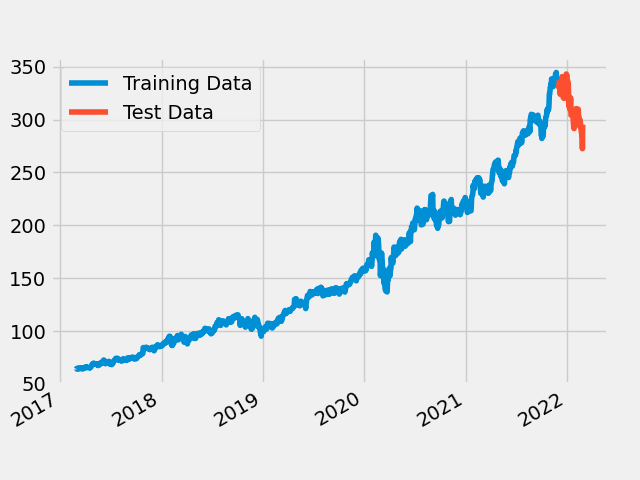

In [5]:
# Plot the training and testing data
train_set.Open.plot(label='Training Data')
test_set.Open.plot(label='Test Data')
plt.legend()

In [6]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
train_scaled = transformer.fit_transform(train_set)
test_scaled = transformer.fit_transform(test_set)

In [7]:
from tensorflow import keras

model = keras.models.load_model(abspath('../../../logs/MSFT-5-Year'), compile=False)

2022-03-01 01:07:24.294736: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-01 01:07:24.295328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-01 01:07:24.295534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 560

systemMemory: 16.00 GB
maxCacheSize: 2.00 GB



In [8]:
inputs = df[len(df)-len(test_set)-60 : ].values
inputs = inputs.reshape(-1,1)
inputs = transformer.transform(inputs)

In [9]:
import numpy as np

x_test = []
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

(63, 60, 1)


In [10]:
predicted = model.predict(x_test)
predicted = transformer.inverse_transform(predicted)

2022-03-01 01:07:28.427467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-01 01:07:28.540898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [11]:
print(predicted.shape)

# Convert the predicted values to a dataframe
predicted_df = pd.DataFrame(predicted)

# Rename the column to "Open"
predicted_df.columns = ['Open']

# Add a new column called "Date" that has the same index as the other dataframe
predicted_df['Date'] = df[len(df)-len(test_set)-0 : ].index

# Set the 'Date' column as the index
predicted_df = predicted_df.set_index('Date')

predicted_df.head()

(63, 1)


,Open
Date,
2021-11-26,341.217896
2021-11-29,340.159882
2021-11-30,338.907684
2021-12-01,337.895020
2021-12-02,337.191681


<AxesSubplot:xlabel='Date'>

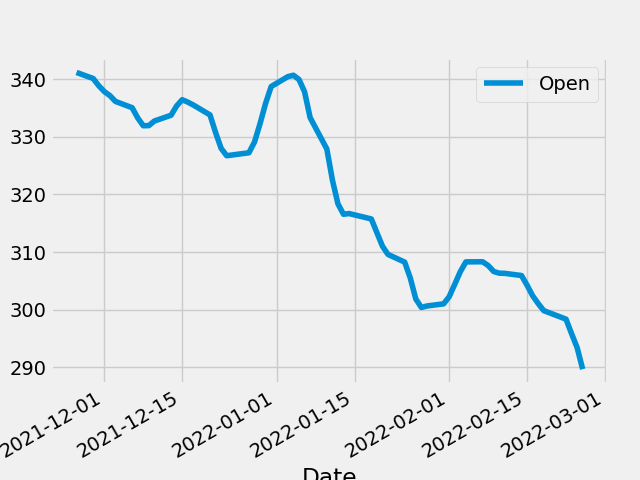

In [12]:
# Plot the predicted values
predicted_df.plot(label='Predicted')

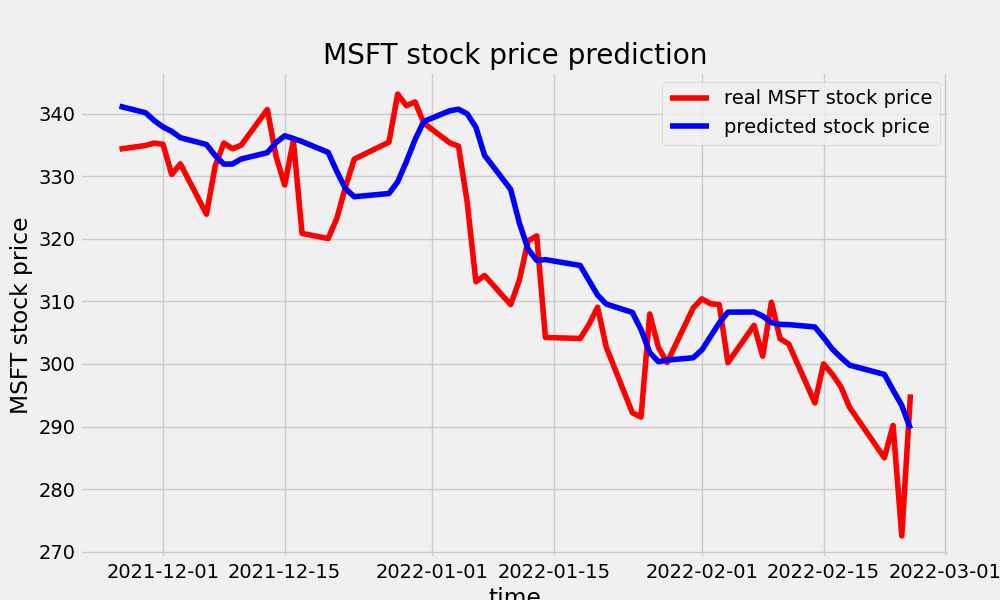

In [13]:
def plot_predictions(test, predicted, figure_number):
    plt.figure(figure_number, figsize=(10,6))
    plt.plot(test, color="red", label="real MSFT stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("MSFT stock price prediction")
    plt.xlabel("time")
    plt.ylabel("MSFT stock price")
    plt.legend()
    plt.show()

plot_predictions(test_set, predicted_df, 4)

In [14]:
import math
from sklearn.metrics import mean_squared_error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is: {}".format(rmse))
    return rmse

RMSE = return_rmse(test_set, predicted)

the root mean squared error is: 8.995895335746004


In [18]:
# Predict the model on future data

NUMBER_OF_PREDICTIONS = 10

future_predictions = []

predicted_future = model.predict(x_test[-1].reshape(1,60,1))
predicted_future = transformer.inverse_transform(predicted_future)
future_predictions.append(predicted_future.flatten())

temp_df = None

def get_last_60_days_data():
    global temp_df
    # get the length of future predictions
    future_predictions_length = len(future_predictions)
    # compute how much more data is required to reach 60
    remaining_length = 60 - future_predictions_length
    # get remaining_length data from the dataframe
    last_60_days_data = df[-remaining_length:]
    # add a row to the dataframe
    for x in future_predictions:
        last_60_days_data.loc[last_60_days_data.index[-1] + pd.Timedelta(days=1)] = x
    temp_df = last_60_days_data
    # user transformer to scale the data
    last_60_days_data = transformer.transform(last_60_days_data)
    # convert last_60_days_data to a numpy array and return it
    return np.array(last_60_days_data)

for i in range(NUMBER_OF_PREDICTIONS):
    prediction = model.predict(get_last_60_days_data().reshape(1,60,1))
    prediction = transformer.inverse_transform(prediction)
    future_predictions.append(prediction.flatten())



# # Create a dataframe with future_predictions
future_predictions_df = pd.DataFrame(future_predictions)
future_predictions_df.columns = ['Open']
# Get the last ten indices of the index of temp_df
future_predictions_df['Date'] = temp_df.index[-11:]
# Set the 'Date' column as the index
future_predictions_df = future_predictions_df.set_index('Date')

print(future_predictions)


[array([289.63715], dtype=float32), array([287.4274], dtype=float32), array([287.61914], dtype=float32), array([287.78793], dtype=float32), array([287.9303], dtype=float32), array([288.0538], dtype=float32), array([288.1657], dtype=float32), array([288.27115], dtype=float32), array([288.37323], dtype=float32), array([288.47375], dtype=float32), array([288.57388], dtype=float32)]


<AxesSubplot:xlabel='Date'>

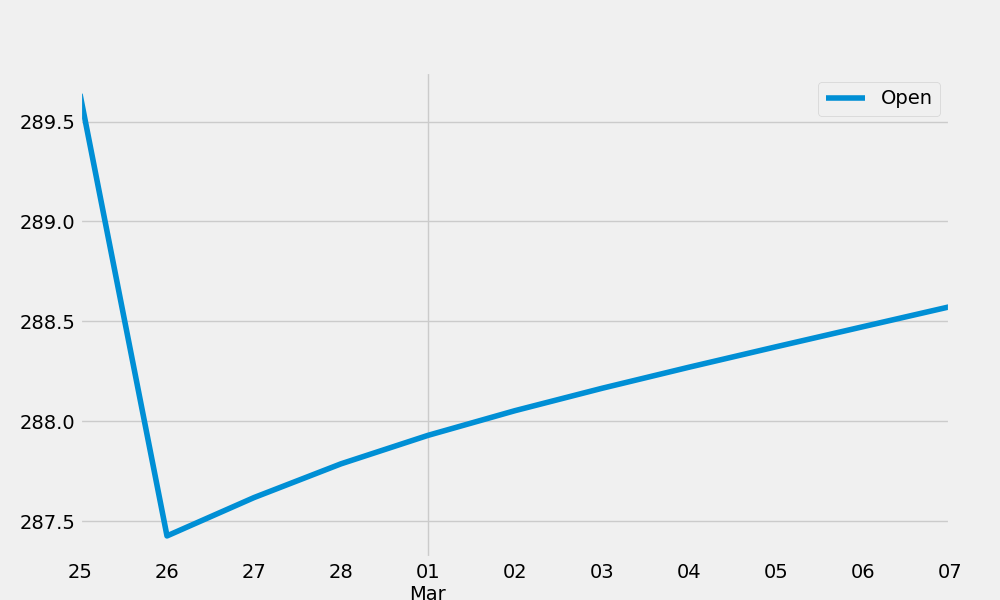

In [19]:
future_predictions_df.plot(label='Predicted', figsize=(10,6))

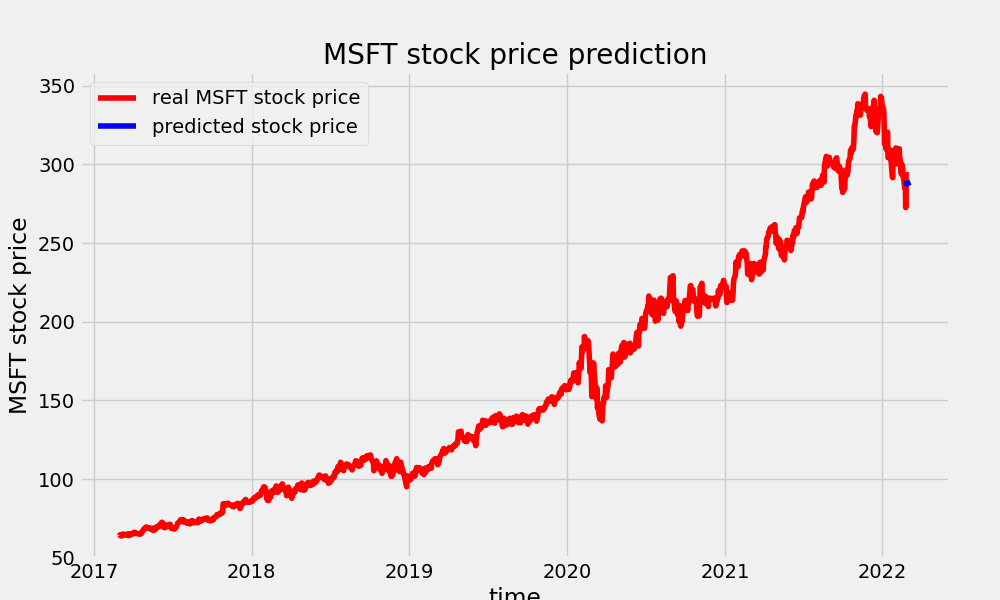

In [21]:
# Plot future_predictions_df alongside test and predicted
plot_predictions(df, future_predictions_df, 10)